#Project Code


---


## Task 1 training Resnet-18 ( CNN ) Model on Colorectal cancer dataset.

###Imports

In [10]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import time
from typing_extensions import Self
from scipy import stats
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.metrics import multilabel_confusion_matrix
from torchvision.models import resnet18

In [11]:
pip install thop

In [12]:
from thop import profile

### Importing datasets from github.

In [13]:
!wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
import colab_github
colab_github.github_auth(persistent_key=True)

# method to import git data into colab taken from:
# https://github.com/tsunrise/colab-github

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Looks that a private key is already created. If you have already push it to github, no action required.
 Otherwise, Please go to https://github.com/settings/ssh/new to upload the following key: 
ssh-ed25519 AAAAC3NzaC1lZDI1NTE5AAAAIKsdgQltK+JTZbl5J1o7j408pGhjNyf4YUbWJmSugvZz root@b884b6fcbf02

Please use SSH method to clone repo.


cloning

In [14]:
!git clone git@github.com:jonq-q/Comp432-GroupQ.git

fatal: destination path 'Comp432-GroupQ' already exists and is not an empty directory.


### Data Onboarding

In [15]:
dataset = datasets.ImageFolder("/content/Comp432-GroupQ/Dataset 1/Colorectal Cancer /", transforms.Compose([
        torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))

train_set, test_set = torch.utils.data.random_split(dataset,[0.7,0.3])                # splits dataset into specified ratios
train_loader = DataLoader(train_set,shuffle=True,batch_size=32, num_workers=0)         # create train loader
test_loader = DataLoader(test_set,batch_size=32, num_workers=0)  # create test loader

### Model 1 creation: Resnet - 18: CNN (no pretraining)

In [16]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

if torch.cuda.is_available():
    model = model.to('cuda')

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model training

In [17]:
num_epochs = 20
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    current_loss = 0.0
    correct = 0
    total = 0
    round = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        y_pred = model(inputs)
        l = loss(y_pred, labels)
        l.backward()
        optimizer.step()

        current_loss += l.item()
        _, predicted = torch.max(y_pred.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training time for one epoch: {elapsed_time} seconds")
    train_accuracy = 100 * correct / total
    train_loss = current_loss / len(train_loader)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')

Training time for one epoch: 51.661521196365356 seconds
Epoch 1/20, Loss: 1.3459, Accuracy: 72.40%
Training time for one epoch: 38.186710596084595 seconds
Epoch 2/20, Loss: 0.4421, Accuracy: 82.86%
Training time for one epoch: 51.16659379005432 seconds
Epoch 3/20, Loss: 0.3635, Accuracy: 86.31%
Training time for one epoch: 38.481555700302124 seconds
Epoch 4/20, Loss: 0.3327, Accuracy: 87.36%
Training time for one epoch: 39.73730182647705 seconds
Epoch 5/20, Loss: 0.2746, Accuracy: 89.31%
Training time for one epoch: 37.90242576599121 seconds
Epoch 6/20, Loss: 0.2603, Accuracy: 90.62%
Training time for one epoch: 38.53290319442749 seconds
Epoch 7/20, Loss: 0.2217, Accuracy: 91.93%
Training time for one epoch: 37.69361472129822 seconds
Epoch 8/20, Loss: 0.2025, Accuracy: 92.38%
Training time for one epoch: 38.48237919807434 seconds
Epoch 9/20, Loss: 0.1979, Accuracy: 92.40%
Training time for one epoch: 38.22734308242798 seconds
Epoch 10/20, Loss: 0.1846, Accuracy: 93.05%
Training time fo

Flop calculation

In [ ]:
# Input tensor (batch size, channels, height, width)
input_tensor = torch.randn(1, 3, 224, 224).to('cuda')

flops, params = profile(model, inputs=(input_tensor,))

print(f"Number of FLOPs: {flops / 1e9} G FLOPs")

Code validation

In [19]:
val_loss = []

with torch.no_grad():
          model.eval()
          running_loss = 0.0
          running_score = 0.0
          for image,label in test_loader:
                image = image.to('cuda')
                label = label.to('cuda')
                optimizer.zero_grad()
                y_pred = model.forward(image)
                l = loss(y_pred,label)
                running_loss += l.item()

                val, index_ = torch.max(y_pred,axis=1)
                running_score += torch.sum(index_ == label.data).item()

          epoch_score = running_score/len(test_loader.dataset)
          epoch_loss = running_loss/len(test_loader.dataset)
          val_loss.append(epoch_loss)
          print("Validation loss: {}, accuracy: {}".format(epoch_loss,epoch_score))

          all_predictions = []
          true_labels = []
          for inputs, labels in test_loader:
              inputs, labels = inputs.to('cuda'), labels.to('cuda')
              outputs = model.forward(inputs)
              _, predicted = torch.max(outputs.data, 1)
              all_predictions.extend(predicted.cpu().numpy())
              true_labels.extend(labels.cpu().numpy())

classification_rep = classification_report(true_labels, all_predictions, target_names=dataset.classes)
print(classification_rep)

Validation loss: 0.011552617489877674, accuracy: 0.8866666666666667
              precision    recall  f1-score   support

         MUS       0.78      0.97      0.87       600
        NORM       0.98      0.97      0.98       597
         STR       0.94      0.73      0.82       603

    accuracy                           0.89      1800
   macro avg       0.90      0.89      0.89      1800
weighted avg       0.90      0.89      0.89      1800



Saving trained model (note: may require adjusting directories depending on your drive)

In [20]:
torch.save(model.state_dict(), '/content/drive/My Drive/TrainedModel')

In [ ]:
pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

#RostislavRu
#pretrained_model.load_state_dict(torch.load('/content/drive/My Drive/Comp 432/TrainedModel', map_location=torch.device('cuda')),strict=False)

#Jonq-q
pretrained_model.load_state_dict(torch.load('/content/drive/My Drive/TrainedModel', map_location=torch.device('cuda')),strict=False)

Checking model after saving

In [22]:
pretrained_model.to('cuda')

with torch.no_grad():
          pretrained_model.eval()
          all_predictions = []
          true_labels = []
          for inputs, labels in test_loader:
              inputs, labels = inputs.to('cuda'), labels.to('cuda')
              outputs = pretrained_model.forward(inputs)
              _, predicted = torch.max(outputs.data, 1)
              all_predictions.extend(predicted.cpu().numpy())
              true_labels.extend(labels.cpu().numpy())

classification_rep = classification_report(true_labels, all_predictions, target_names=dataset.classes)
print(classification_rep)

              precision    recall  f1-score   support

         MUS       0.78      0.97      0.86       600
        NORM       0.98      0.98      0.98       597
         STR       0.95      0.72      0.82       603

    accuracy                           0.89      1800
   macro avg       0.91      0.89      0.89      1800
weighted avg       0.91      0.89      0.89      1800



Confusion matrix

In [23]:
confMatrix = multilabel_confusion_matrix(true_labels, all_predictions, labels=[0, 1, 2])
print(confMatrix)

[[[1033  167]
  [  16  584]]

 [[1194    9]
  [  13  584]]

 [[1176   21]
  [ 168  435]]]


Model layers

In [ ]:
pretrained_model

### Model visualization on Dataset 1 with t-SNE

### Approach 1

In [25]:
device=torch.device("cuda:0"if torch.cuda.is_available() else "cpu")

In [26]:
from typing_extensions import Self
#print(list(pretrained_model.children()))
features=list(pretrained_model.children())[:-1] #only remove fc
model_out=nn.Sequential(*features).to(device)
def for_feature(loader):
  data_tmp=[]
  label_tmp=[]

  with torch.no_grad():
      for img,label in loader:
        img=img.to(device)

        output1=model_out(img)

        data_tmp.append(output1.cpu().numpy())
        label_tmp.append(label.cpu().numpy())

  return np.vstack(data_tmp), np.hstack(label_tmp)

In [27]:
trained_feature, trained_label=for_feature(train_loader)

In [28]:
trained_feature_n = trained_feature.reshape(4200,512)

In [29]:
from scipy import stats
stats.describe(trained_label)

DescribeResult(nobs=4200, minmax=(0, 2), mean=0.9992857142857143, variance=0.6661104684788896, skewness=0.0013115221381791054, kurtosis=-1.4983888374405672)

In [30]:
tsne=TSNE(n_components=2, random_state=0, learning_rate='auto')
projections=tsne.fit_transform(trained_feature_n)
fig=px.scatter(projections[:,0], projections[:,1], color = trained_label, labels={"color":""})
fig.show()

### Approach 2

In [31]:
dataset1 = datasets.ImageFolder("/content/Comp432-GroupQ/Dataset 1/Colorectal Cancer ", transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))

dataloader_sc = DataLoader(dataset1, batch_size=64, shuffle=True)

In [32]:
features = list(pretrained_model.children())[:-1] #only remove fc
resnet_nohead = nn.Sequential(*features).to(device)
resnet_nohead = resnet_nohead.eval()

In [33]:
all_features = []
all_labels = []

resnet_nohead.to(device)

with torch.no_grad():
    for images, labels in dataloader_sc:
        images = images.to(device)
        labels = labels.to(device)
        features = resnet_nohead(images)
        features = features.squeeze().cpu().numpy()
        all_features.append(features)
        all_labels.append(labels.cpu().numpy())

# Concatenate features and labels
all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

In [34]:
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(all_features)

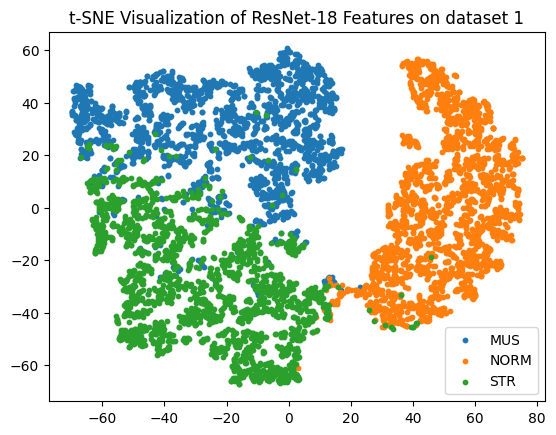

In [35]:
# Plot the t-SNE embeddings with different colors for each class
plt.scatter(embedded_features[all_labels == 0, 0], embedded_features[all_labels == 0, 1], label='MUS',s=10)
plt.scatter(embedded_features[all_labels == 1, 0], embedded_features[all_labels == 1, 1], label='NORM',s=10)
plt.scatter(embedded_features[all_labels == 2, 0], embedded_features[all_labels == 2, 1], label='STR',s=10)

plt.title('t-SNE Visualization of ResNet-18 Features on dataset 1')
plt.legend()
plt.show()

## Task 2: Pre-trained CNN applications on different datasets

###Scenario 1: Locally trained CNN applied to dataset 2, with KNN and SVM classification

In [36]:
#task 2 Pretrained ResNet18 applied to Dataset2 & 3
dataset2 = datasets.ImageFolder("/content/Comp432-GroupQ/Dataset 2/Prostate Cancer/", transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))

dataloader_sc1 = DataLoader(dataset2, batch_size=64, shuffle=True)

In [37]:
features = list(pretrained_model.children())[:-1] #only remove fc
resnet_nohead = nn.Sequential(*features).to(device)
resnet_nohead = resnet_nohead.eval()

model output extraction

In [38]:
all_features = []
all_labels = []

resnet_nohead.to(device)

with torch.no_grad():
    for images, labels in dataloader_sc1:
        images = images.to(device)
        labels = labels.to(device)
        features = resnet_nohead(images)
        features = features.squeeze().cpu().numpy()
        all_features.append(features)
        all_labels.append(labels.cpu().numpy())

# Concatenate features and labels
all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

t-SNE

In [39]:
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(all_features)

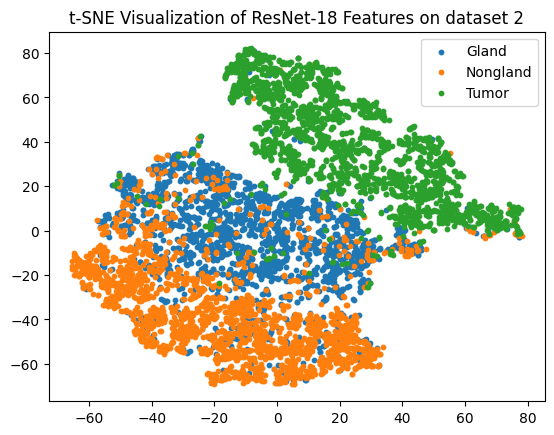

In [40]:
# Plot the t-SNE embeddings with different colors for each class
plt.scatter(embedded_features[all_labels == 0, 0], embedded_features[all_labels == 0, 1], label='Gland',s=10)
plt.scatter(embedded_features[all_labels == 1, 0], embedded_features[all_labels == 1, 1], label='Nongland',s=10)
plt.scatter(embedded_features[all_labels == 2, 0], embedded_features[all_labels == 2, 1], label='Tumor',s=10)

plt.title('t-SNE Visualization of ResNet-18 Features on dataset 2')
plt.legend()
plt.show()

### KNN classification

In [41]:
def extract_features(model, dataloader):
    model.eval()
    all_features, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            features = model(images)
            all_features.append(features.squeeze().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.vstack(all_features), np.array(all_labels)

# Extract features from the dataset
features, labels = extract_features(resnet_nohead, dataloader_sc1)

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Create k-NN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)

# Evaluate the model
accuracy = knn_classifier.score(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 90.17%


In [44]:
y_pred_knn = knn_classifier.predict(X_test)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.83      0.85       591
           1       0.86      0.91      0.88       600
           2       0.98      0.97      0.97       609

    accuracy                           0.90      1800
   macro avg       0.90      0.90      0.90      1800
weighted avg       0.90      0.90      0.90      1800



In [45]:
from sklearn.metrics import multilabel_confusion_matrix

confMatrix_knn = multilabel_confusion_matrix(y_test, y_pred_knn)
print(confMatrix_knn)

[[[1139   70]
  [ 103  488]]

 [[1108   92]
  [  57  543]]

 [[1176   15]
  [  17  592]]]


### SVM Classification

In [46]:
from sklearn import svm

svm_classifier = svm.SVC()
svm_classifier.fit(X_train, y_train)

# Evaluate the SVM model
y_pred_svm = svm_classifier.predict(X_test)

In [47]:
print("Classification Report (SVM):\n", classification_report(y_test, y_pred_svm))

Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.88      0.84      0.86       591
           1       0.86      0.91      0.88       600
           2       0.98      0.98      0.98       609

    accuracy                           0.91      1800
   macro avg       0.91      0.91      0.91      1800
weighted avg       0.91      0.91      0.91      1800



In [48]:
confMatrix_svm = multilabel_confusion_matrix(y_test, y_pred_svm)
print(confMatrix_svm)

[[[1143   66]
  [  96  495]]

 [[1114   86]
  [  56  544]]

 [[1177   14]
  [  14  595]]]


## Scenario 2: Locally trained CNN on Dataset 3

In [49]:
dataset3 = datasets.ImageFolder("/content/Comp432-GroupQ/Dataset 3/Animal Faces", transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))

dataloader_sc2 = DataLoader(dataset2, batch_size=64, shuffle=True)

In [50]:
all_features = []
all_labels = []

resnet_nohead.to(device)

with torch.no_grad():
    for images, labels in dataloader_sc1:
        images = images.to(device)
        labels = labels.to(device)
        features = resnet_nohead(images)
        features = features.squeeze().cpu().numpy()
        all_features.append(features)
        all_labels.append(labels.cpu().numpy())

# Concatenate features and labels
all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

In [51]:
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(all_features)

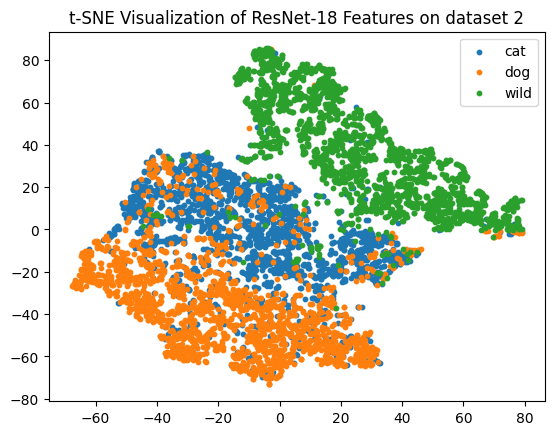

In [52]:
# Plot the t-SNE embeddings with different colors for each class
plt.scatter(embedded_features[all_labels == 0, 0], embedded_features[all_labels == 0, 1], label='cat',s=10)
plt.scatter(embedded_features[all_labels == 1, 0], embedded_features[all_labels == 1, 1], label='dog',s=10)
plt.scatter(embedded_features[all_labels == 2, 0], embedded_features[all_labels == 2, 1], label='wild',s=10)

plt.title('t-SNE Visualization of ResNet-18 Features on dataset 2')
plt.legend()
plt.show()

### Scenario 3: Pre-trained (ImageNet) CNN applied to dataset 2

Model declaration

In [53]:
net_pre=resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
net_pre.fc=nn.Linear(net_pre.fc.in_features,3)
features = list(net_pre.children())[:-1] #only remove fc
resnet_nohead = nn.Sequential(*features).to(device)
resnet_nohead = resnet_nohead.eval()

In [54]:
all_features_pre_2 = []
all_labels_pre_2 = []

resnet_nohead.to(device)

with torch.no_grad():
    for images, labels in dataloader_sc1:
        images = images.to(device)
        labels = labels.to(device)
        features = resnet_nohead(images)
        features = features.squeeze().cpu().numpy()
        all_features_pre_2.append(features)
        all_labels_pre_2.append(labels.cpu().numpy())

# Concatenate features and labels
all_features_pre_2= np.concatenate(all_features_pre_2, axis=0)
all_labels_pre_2 = np.concatenate(all_labels_pre_2, axis=0)

In [55]:
tsne = TSNE(n_components=2, random_state=42)
embedded_features_pre_2 = tsne.fit_transform(all_features_pre_2)

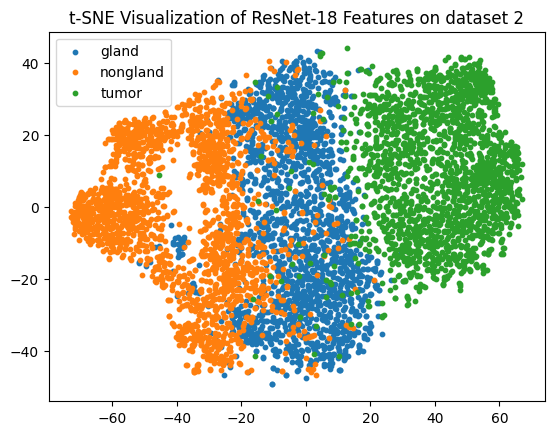

In [56]:
# Plot the t-SNE embeddings with different colors for each class
plt.scatter(embedded_features_pre_2[all_labels_pre_2 == 0, 0], embedded_features_pre_2[all_labels_pre_2 == 0, 1], label='gland', s=10)
plt.scatter(embedded_features_pre_2[all_labels_pre_2 == 1, 0], embedded_features_pre_2[all_labels_pre_2 == 1, 1], label='nongland', s=10)
plt.scatter(embedded_features_pre_2[all_labels_pre_2 == 2, 0], embedded_features_pre_2[all_labels_pre_2 == 2, 1], label='tumor', s=10)

plt.title('t-SNE Visualization of ResNet-18 Features on dataset 2')
plt.legend()
plt.show()

### Scenario 4: Pre-trained (ImageNet) CNN applied to dataset 3

In [59]:
all_features_pre_3 = []
all_labels_pre_3= []

resnet_nohead.to(device)

with torch.no_grad():
    for images, labels in dataloader_sc2:
        images = images.to(device)
        labels = labels.to(device)
        features = resnet_nohead(images)
        features = features.squeeze().cpu().numpy()
        all_features_pre_3.append(features)
        all_labels_pre_3.append(labels.cpu().numpy())

# Concatenate features and labels
all_features_pre_3= np.concatenate(all_features_pre_3, axis=0)
all_labels_pre_3 = np.concatenate(all_labels_pre_3, axis=0)

In [60]:
tsne = TSNE(n_components=2, random_state=42)
embedded_features_pre_3 = tsne.fit_transform(all_features_pre_3)

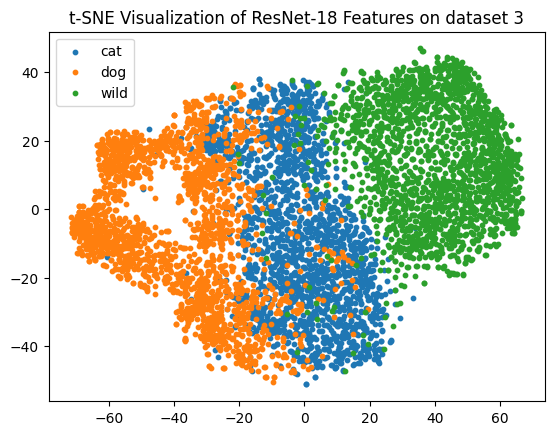

In [61]:
plt.scatter(embedded_features_pre_3[all_labels_pre_3 == 0, 0], embedded_features_pre_3[all_labels_pre_3 == 0, 1], label='cat',s=10)
plt.scatter(embedded_features_pre_3[all_labels_pre_3 == 1, 0], embedded_features_pre_3[all_labels_pre_3 == 1, 1], label='dog',s=10)
plt.scatter(embedded_features_pre_3[all_labels_pre_3 == 2, 0], embedded_features_pre_3[all_labels_pre_3 == 2, 1], label='wild',s=10)

plt.title('t-SNE Visualization of ResNet-18 Features on dataset 3')
plt.legend()
plt.show()